In [1]:
import sys

# Replace with your path to the cloned repository (/path/to/torchVAE)
root_path = '/cs/cs152/individual/rohan/semisupervisedVAE/'

if root_path not in sys.path:
    sys.path.insert(1, root_path)
    
from models.cpcvae import ConsistencyConstrainedVAE
from utils.vistools import *
from utils.datatools import load_data, EncodedDataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load trained PCVAE

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        init_channels = 16
        self.conv1 = nn.Conv2d(1, init_channels, kernel_size=3, padding=1, stride=2)
        self.skip_conv1 = nn.Conv2d(1, init_channels, kernel_size=3, padding=1, stride=2)
        self.conv2 =  nn.Conv2d(init_channels, init_channels*2, kernel_size=3, padding=1, stride=2)
        self.skip_conv2 =  nn.Conv2d(init_channels, init_channels*2, kernel_size=3, padding=1, stride=2)
        self.conv3 =  nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, padding=1, stride=2)
        self.skip_conv3 =  nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, padding=1, stride=2)
        self.activation = nn.ReLU()

        self.linear_mu = nn.Linear(init_channels*4*4*4,latent_dims)
        self.linear_sigma = nn.Linear(init_channels*4*4*4,latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = self.activation(self.conv1(x))+self.skip_conv1(x)
        x = self.activation(self.conv2(x))+self.skip_conv2(x)
        x = self.activation(self.conv3(x))+self.skip_conv3(x)
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear_mu(x)
        logvar = self.linear_sigma(x)
        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().pow(2))
        sigma = torch.exp(logvar/2)
        return mu, sigma
    
    def sample(self, mu, sigma):
        N = torch.distributions.Normal(0, 1)
        z = mu + sigma * self.N.sample(mu.shape)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        init_channels = 16
        self.linear = nn.Linear(latent_dims, init_channels*4*4*4)
        self.convT1 = nn.ConvTranspose2d(init_channels*4,init_channels*2,kernel_size=2,stride=2)
        self.skip_convT1 = nn.ConvTranspose2d(init_channels*4,init_channels*2,kernel_size=2,stride=2)
        self.convT2 = nn.ConvTranspose2d(init_channels*2,init_channels,kernel_size=2,stride=2)
        self.skip_convT2 = nn.ConvTranspose2d(init_channels*2,init_channels,kernel_size=2,stride=2)
        self.convT3 = nn.ConvTranspose2d(init_channels,1,kernel_size=2,stride=2,padding=2)
        self.skip_convT3 = nn.ConvTranspose2d(init_channels,1,kernel_size=2,stride=2,padding=2)
        self.activation = nn.ReLU()

    def forward(self, z):
        init_channels = 16
        z = self.activation(self.linear(z))
        z = z.reshape((-1, init_channels*4, 4, 4))
        z = self.activation(self.convT1(z))+self.skip_convT1(z)
        z = self.activation(self.convT2(z))+self.skip_convT2(z)
        z = self.activation(self.convT3(z))+self.skip_convT3(z)
        return z

    def sample():
        return None
    

class LogisticRegression(nn.Module):
    def __init__(self, latent_dims, classes):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(latent_dims, classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x=torch.flatten(x,start_dim=1)
        return self.softmax(self.linear(x))
    

class VAEClassifer(nn.Module):
    def __init__(self, latent_dims,classes):
        super(VAEClassifer, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        self.classifier = LogisticRegression(latent_dims,classes)

    def forward(self, x):
        mu,sigma = self.encoder(x)
        z = mu + sigma*self.encoder.N.sample(mu.shape)
        #x_hat = VAE.decoder(z)
        #y_pred = self.classifier(z)
        return self.decoder(z), self.classifier(z)

cpcvae = VAEClassifer(latent_dims=10, classes=10)

In [ ]:
#  saved_model = "../checkpoints/test_cpcvae_mnist_agg"
# saved_model = "../mnist_model100labels_aggregate_label.sav"
saved_model = "best_models/mnist_model100labels_aggregate_label_long.sav"

In [5]:
state_dict = torch.load(saved_model)
cpcvae.load_state_dict(state_dict)
cpcvae.eval()
cpcvae.to(device)

VAEClassifer(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation): ReLU()
    (linear_mu): Linear(in_features=1024, out_features=10, bias=True)
    (linear_sigma): Linear(in_features=1024, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=10, out_features=1024, bias=True)
    (convT1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (skip_convT1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (convT2): ConvTranspose2d(32, 16, kernel_size=(2, 

### Get data

In [3]:
import torchvision
from sklearn.model_selection import train_test_split

batch_size = 50
valid_batch_size = 6000

class SimpleDataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

data = torchvision.datasets.MNIST('./mnist_data', transform=torchvision.transforms.ToTensor(), download=True, train=True)
images, labels = zip(*data)
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=.1, stratify=labels, random_state=72)
unlabelled_images, labelled_images, unlabelled_labels, labelled_labels = train_test_split(train_images, train_labels, test_size=100/len(train_labels), stratify=train_labels, random_state=54)

labelled_train_data = torch.utils.data.DataLoader(SimpleDataset(labelled_images, labelled_labels),batch_size=batch_size,shuffle=True)
unlabelled_train_data = torch.utils.data.DataLoader(SimpleDataset(unlabelled_images, unlabelled_labels),batch_size=batch_size,shuffle=True)
valid_data = torch.utils.data.DataLoader(SimpleDataset(valid_images, valid_labels),batch_size=valid_batch_size,shuffle=True)

test_data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./mnist_data',
               transform=torchvision.transforms.ToTensor(),
               download=True, train=False),
        batch_size=1000,
        shuffle=True)

In [7]:
print(len(labelled_images))
print(len(unlabelled_images))
print(len(valid_images))

100
53900
6000


In [13]:
def encode(x, device):
    with torch.no_grad():
        cpcvae.encoder.eval()
        x = x.to(device)
        mean, logvar = cpcvae.encoder(x.to(device))
        
        # Sample an image from the distribution
        z = cpcvae.encoder.sample(mean, logvar)
        z = z.detach()
        
        return z
    
encoded_label_data = EncodedDataset(SimpleDataset(labelled_images, labelled_labels), encode, device)
encoded_unlabel_data = EncodedDataset(SimpleDataset(unlabelled_images, unlabelled_labels), encode, device)
encoded_val_data = EncodedDataset(SimpleDataset(valid_images, valid_labels), encode, device)
print(f'Encoded train data shape: {encoded_label_data[0][0].shape}')

train_label_dataLoader = DataLoader(encoded_label_data, batch_size=batch_size, shuffle=True)
train_unlabel_dataLoader = DataLoader(encoded_unlabel_data, batch_size=batch_size, shuffle=True)
valid_dataLoader = DataLoader(encoded_val_data, batch_size=batch_size, shuffle=False)

100%|██████████| 6000/6000 [00:04<00:00, 1351.29it/s]

Encoded train data shape: torch.Size([1, 10])


### Compute accuracy of classifier 

In [14]:
def validate(model, dataLoader, device, input_size, loss_fn):
    model.eval()
    accurate = 0
    total = 0
    dl_losses = []

    with torch.no_grad():
        for images,labels in dataLoader:
            
            
            images = images.view(-1, input_size).to(device)
            
            labels = labels.to(device)
            
            # print(f"{images.shape=}, {labels.shape=}")
    
            output = model(images)
            # print(f"{output.shape=}")
            _,predicted = torch.max(output.data, 1)
    
            # compute loss
            dl_losses.append(loss_fn(output, labels).item())
            
            # total labels
            total += labels.size(0)
            
            # total correct predictions
            accurate += (predicted == labels).sum().item()
    
    accuracy_score = 100 * accurate/total
    return np.mean(dl_losses), accuracy_score

In [15]:
validate(cpcvae.classifier, train_label_dataLoader, device=device, input_size=10, loss_fn=nn.CrossEntropyLoss())

(1.4614089131355286, 100.0)

In [16]:
validate(cpcvae.classifier, train_unlabel_dataLoader, device=device, input_size=10, loss_fn=nn.CrossEntropyLoss())

(1.5350843123911926, 93.16326530612245)

In [17]:
validate(cpcvae.classifier, valid_dataLoader, device=device, input_size=10, loss_fn=nn.CrossEntropyLoss())

(1.5367806772391002, 93.11666666666666)

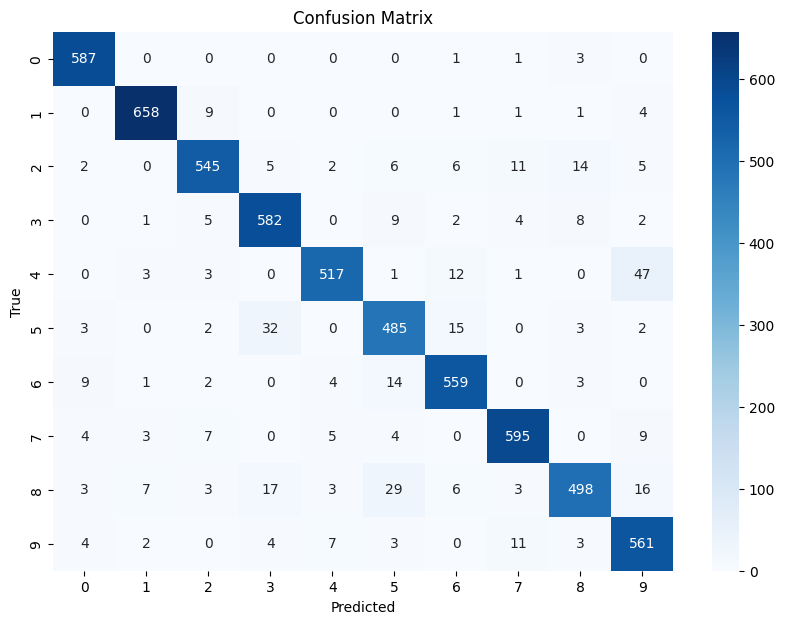

In [29]:
generate_confusion_matrix(cpcvae, valid_dataLoader, device)

### Visualize latent distribution

In [19]:
z_batches, y_batches = get_latent(cpcvae, unlabelled_train_data, num_batches=100, latent_dims=10, device='cuda')

In [20]:
z_batches.shape

torch.Size([5000, 10])

In [21]:
y_batches.shape

torch.Size([5000])

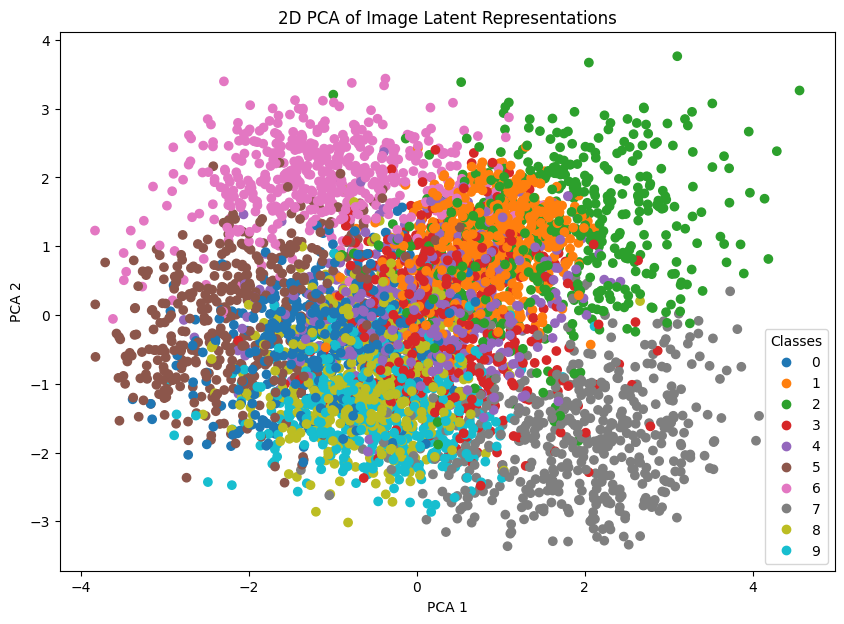

In [22]:
plotPCAdist(z_batches, y_batches)

/cs/cs152/individual/rohan/semisupervisedVAE/utils/vistools.py:104: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


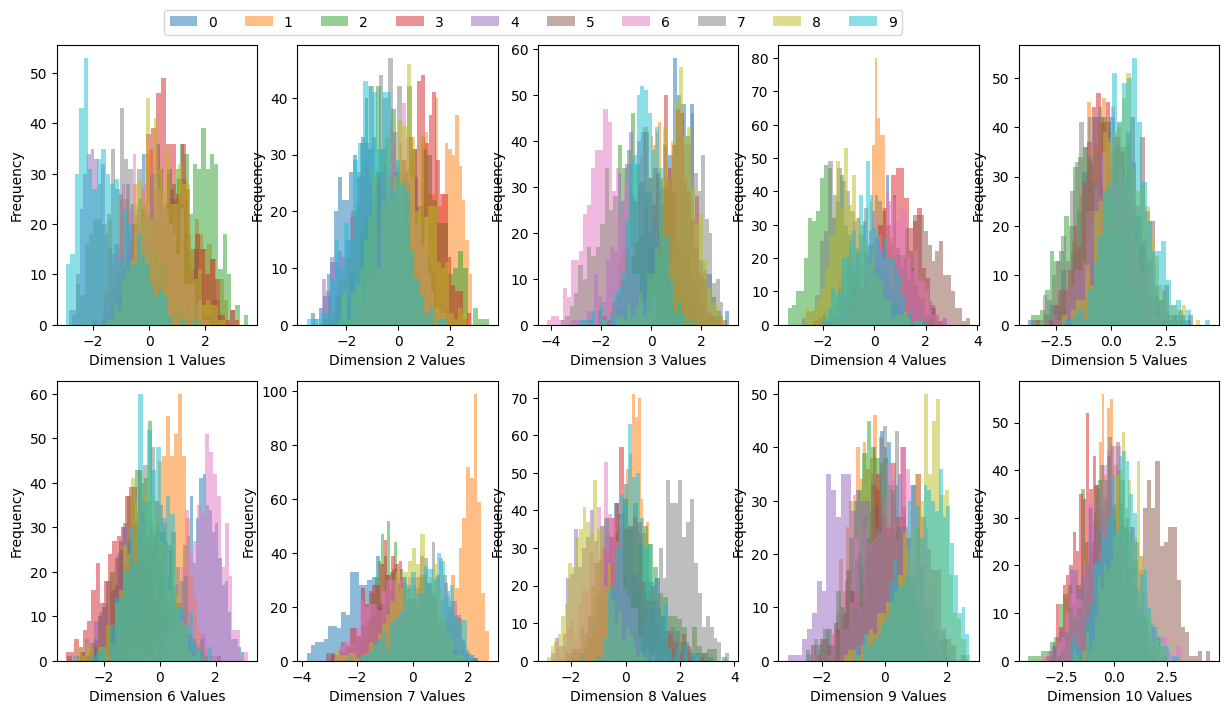

In [23]:
stackedHist(z_batches, y_batches)

### Generate image samples and reconstructions

ValueError: not enough values to unpack (expected 2, got 1)

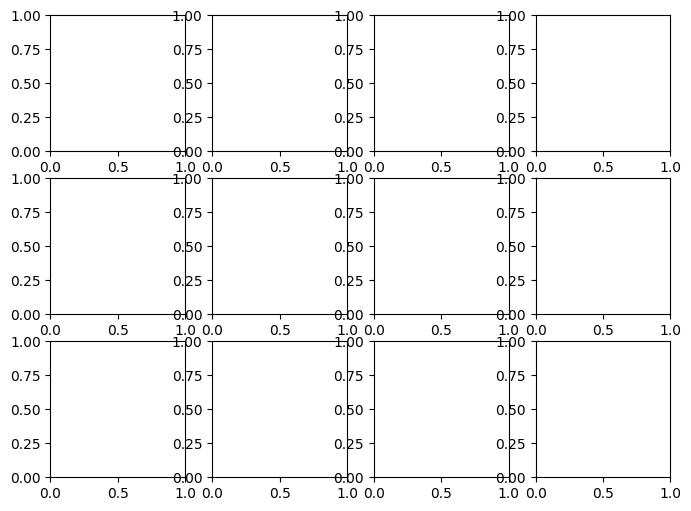

In [26]:
cpcvae.latent_dims = 10
cpcvae.architecture = "conv"
sample_random(cpcvae, n=10)

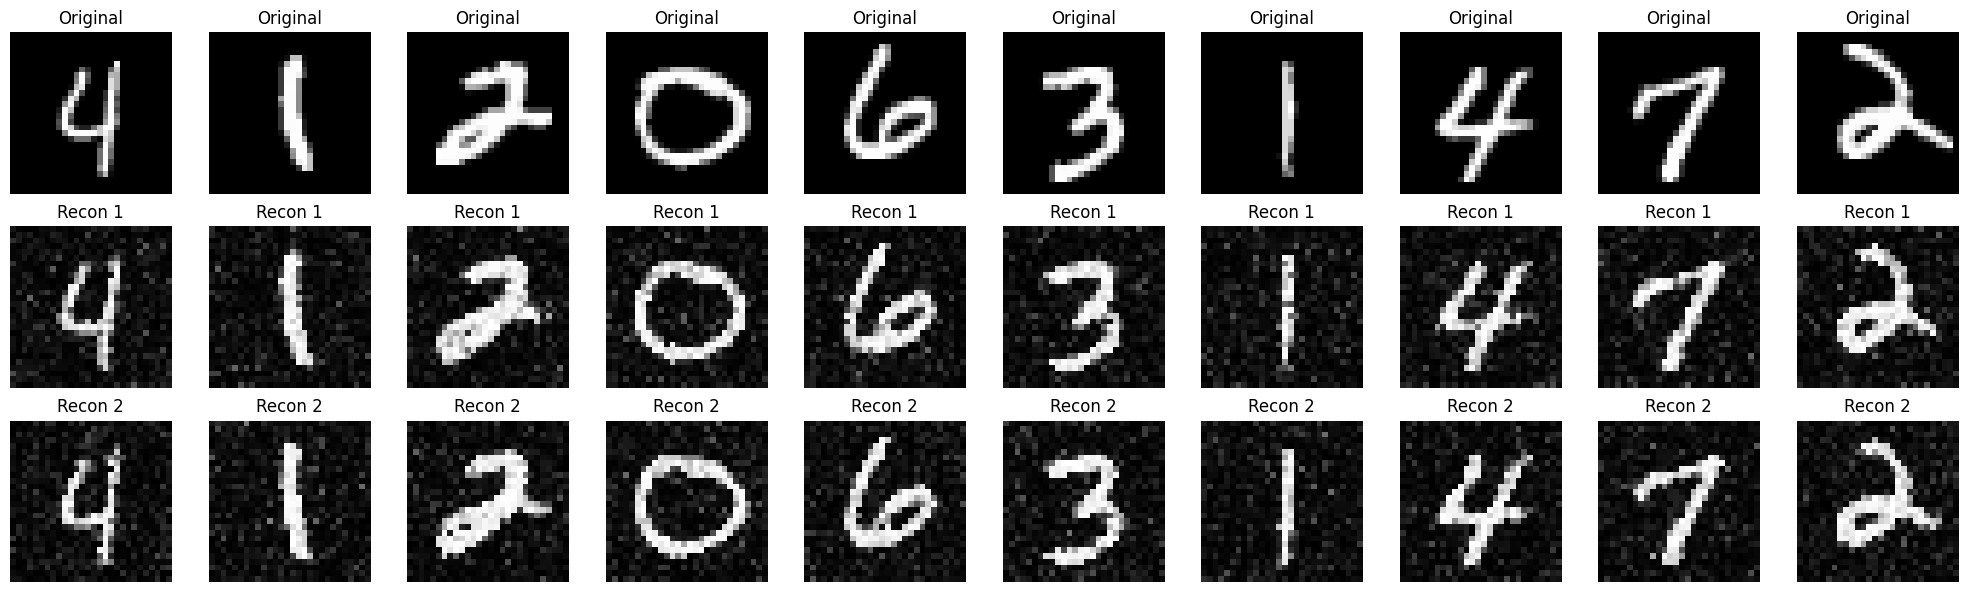

In [18]:
reconstruct_and_compare(cpcvae, dataLoader_u, device, n=10)
